In [92]:
import spacy
from spacy import Language
from collections import defaultdict
import operator
import math
from string import punctuation, ascii_letters, ascii_uppercase, ascii_lowercase, digits
import random
from itertools import *
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy import asarray
from numpy import exp
from numpy.random import randn
from numpy.random import rand
from numpy.random import seed
import errno
from matplotlib import pyplot
import re
from Levenshtein import distance as levenshtein_distance
from sklearn.metrics import accuracy_score, confusion_matrix
#!python -m spacy info
#!pip install spacy==3.0.5
#!pip install spacy==3.0.3
#!pip install sklearn
from zxcvbn import zxcvbn

In [39]:
zxcvbn('qwertyui')

{'password': 'qwertyui',
 'guesses': Decimal('264'),
 'guesses_log10': 2.421603926869831,
 'sequence': [{'pattern': 'dictionary',
   'i': 0,
   'j': 7,
   'token': 'qwertyui',
   'matched_word': 'qwertyui',
   'rank': 263,
   'dictionary_name': 'passwords',
   'reversed': False,
   'l33t': False,
   'base_guesses': 263,
   'uppercase_variations': 1,
   'l33t_variations': 1,
   'guesses': 263,
   'guesses_log10': 2.4199557484897576}],
 'calc_time': datetime.timedelta(0, 0, 7302),
 'crack_times_seconds': {'online_throttling_100_per_hour': Decimal('9504.000000000000527577981302'),
  'online_no_throttling_10_per_second': Decimal('26.4'),
  'offline_slow_hashing_1e4_per_second': Decimal('0.0264'),
  'offline_fast_hashing_1e10_per_second': Decimal('2.64E-8')},
 'crack_times_display': {'online_throttling_100_per_hour': '3 hours',
  'online_no_throttling_10_per_second': '26 seconds',
  'offline_slow_hashing_1e4_per_second': 'less than a second',
  'offline_fast_hashing_1e10_per_second': 'less 

In [2]:
def mkdir_p(path):
    """To make a directory given a path."""
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [3]:
global combs 
combs = []

def printAllKLength(set, k):
 
    n = len(set)
    printAllKLengthRec(set, "", n, k)
 
# The main recursive method
# to print all possible
# strings of length k
def printAllKLengthRec(set, prefix, n, k):
     
    # Base case: k is 0,
    # print prefix
    if (k == 0) :
        return prefix
 
    # One by one add all characters
    # from set and recursively
    # call for k equals to k-1
    for i in range(n):
 
        # Next character of input added
        newPrefix = prefix + set[i]
         
        # k is decreased, because
        # we have added a new character
        combs.append(printAllKLengthRec(set, newPrefix, n, k - 1))


In [4]:
def get_entities_for_text(model=None, text=""):
    doc = model(text)
    print("Entities in '%s'" % text)
    entities = {}
    for ent in doc.ents:
        entities[ent.text] = ent.label_
    return entities

def get_scores_per_entity(model=None, texts=[],):
    # Number of alternate analyses to consider. More is slower, and not necessarily better -- you need to experiment on your problem.
    beam_width = 3
    # This clips solutions at each step. We multiply the score of the top-ranked action by this value, and use the result as a threshold. This prevents the parser from exploring options that look very unlikely, saving a bit of efficiency. Accuracy may also improve, because we've trained on greedy objective.
    beam_density = 0.0001 

    ner = nlp.get_pipe('ner')
    docs = nlp.make_doc(texts[0])
    beams = ner.beam_parse([docs], beam_width=beam_width, beam_density=beam_density)
    #beams = ner.predict([docs])
    
    entity_scores = []
    for beam in beams:
        score_dict = defaultdict(float)
        for score, ents in ner.moves.get_beam_parses(beam):
            for start, end, label in ents:
                score_dict[(start, end, label)] += score
        entity_scores.append(score_dict)
    return entity_scores
    
    #return ner.scored_ents(beams)[0]

def get_scores_per_entity(model=None, texts=[], beam_width=3, r_space=0, secret_token_index=None, secret_index=None, secret=None, LABEL=None):
    """Get probability scores for entities for a list of texts."""
    
    nlp = model

    # Beam_width - Number of alternate analyses to consider. More is slower, and not necessarily better -- you need to experiment on your problem.
    # beam_density - This clips solutions at each step. We multiply the score of the top-ranked action by this value, and use the result as a threshold. This prevents the parser from exploring options that look very unlikely, saving a bit of efficiency. Accuracy may also improve, because we've trained on greedy objective.
    beam_density = 0.0001 

    score_per_combination = {}
    exposure_per_combination = {}

    ner = nlp.get_pipe('ner')

    for text in texts:
        doc = nlp.make_doc(text)
        beams = ner.beam_parse([doc], beam_width=beam_width, beam_density=0.0001)
        entity_scores = defaultdict(float)
        total_score = 0
        
        for score, ents in ner.moves.get_beam_parses(beams[0]):
            total_score += score
            for start, end, label in ents:
                entity_scores[(start, end, label)] += score
        if (secret_token_index,secret_token_index+1,LABEL) not in entity_scores:
            entity_scores[(secret_token_index,secret_token_index+1,LABEL)] = 0.0
        normalized_beam_score = {dict_key: dict_value/total_score for dict_key, dict_value in entity_scores.items()}
        score_per_combination[doc.text.split()[secret_index]] = normalized_beam_score[(secret_token_index,secret_token_index+1,LABEL)]
    #print(score_per_combination[secret])

    sorted_score_per_combination = dict(sorted(score_per_combination.items(), key=operator.itemgetter(1), reverse=True))
    rank = 1
    exposure_rank_secret = -1
    score_secret = -1
    exposure_secret = -1
    for code, score in sorted_score_per_combination.items():
        exposure = math.log2(r_space) - math.log2(rank)
        exposure_per_combination[code] = exposure
        if code == secret:
            exposure_rank_secret = rank
            score_secret = score
            exposure_secret = exposure
        rank += 1

    return score_per_combination, exposure_per_combination, exposure_rank_secret, score_secret, exposure_secret


In [5]:
def generate_password_given_prefix_suffix(prefix=None, suffix=None, length=None,  upper=True, lower=True, numeric=True, special=False):
    
    passwords = []
    if numeric and upper and lower:
        set1 = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        set1.extend(set(ascii_lowercase))
        set1.extend(set(ascii_uppercase))
        printAllKLength(set1, length-4)
        res = [i for i in combs if i]
        for comb in res:
            password = prefix + comb + suffix
            passwords.append(password)
    if upper:
        pass
    if lower:
        pass
    if special:
        pass

    res.clear()
    combs.clear()
    return passwords

def generate_password_given_length(length=0, upper=True, lower=True, numeric=True, special=False):
    passwords = []
    if numeric and upper and lower:
        set1 = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        set1.extend(set(ascii_lowercase))
        set1.extend(set(ascii_uppercase))
        printAllKLength(set1, length)
        res = [i for i in combs if i]
        for comb in res:
            password = prefix + comb + suffix
            passwords.append(password)
    if upper:
        pass
    if lower:
        pass
    if special:
        pass

    res.clear()
    combs.clear()
    return passwords
    

In [6]:
folder = "models/20210406_spacy_3.0.5_with_password_abc123"
updated_nlp = spacy.load(folder)

In [7]:
secret = "abc123"
#secret = "x002kn13039"
text = "Rana's secret is {}".format(secret)
texts = [text]

length = len(secret)

nlp = spacy.load('en_core_web_lg')
print(spacy.__version__)
doc = nlp(text)
tokens = [str(token) for token in doc]
print(tokens)
secret_token_index = tokens.index(secret)
print(secret_token_index)
doc = nlp(text)
LABEL = "SECRET"

start_loc = 17
end_loc = start_loc+length

beam_width = 3

secret_index = doc.text.split().index(secret)
print(secret_index)

3.0.5
['Rana', "'s", 'secret', 'is', 'abc123']
4
3


In [8]:
print(get_entities_for_text(model=nlp, text=text))
#print(get_scores_per_entity(model=nlp, texts=[text]))

score, exposure, exposure_rank_secret, score_secret, exposure_secret = get_scores_per_entity(model=updated_nlp, texts=texts, beam_width=3, r_space=len(texts), secret_token_index=secret_token_index, secret_index=secret_index, secret=secret, LABEL=LABEL)

print(score_secret)

Entities in 'Rana's secret is abc123'
{'Rana': 'PERSON', 'abc123': 'PERSON'}
0.9708132609044945


In [9]:
def objective(x):
    prefix = text[0:int(start_loc)]
    suffix = text[int(end_loc):]
    texts = []
    texts.append(prefix+x+suffix)
    score, exposure, exposure_rank_secret, score_secret, exposure_secret = get_scores_per_entity(model=updated_nlp, texts=texts, beam_width=3, r_space=len(texts), secret_token_index=secret_token_index, secret_index=secret_index, secret=secret, LABEL=LABEL)
    return list(score.values())[0]

In [10]:
prefix = secret[0]
suffix = secret[-3:]

passwords = generate_password_given_prefix_suffix(prefix=prefix, suffix=suffix, length=len(secret),  upper=True, lower=True, numeric=True, special=False)
#passwords = generate_password_given_length(length=6, upper=True, lower=True, numeric=True, special=False)


bounds = np.asarray([passwords])
bounds = bounds.astype(object)                          

In [11]:
passwords_dist = [(password, levenshtein_distance(secret, password)) for password in passwords]

In [12]:
# generate an initial point
best = bounds[0][random.randint(0,len(bounds))]
# evaluate the initial point
best_eval = objective(best)

In [152]:
def generate_random_candidate(word, index_range, history):
    indexes = list(range(index_range[0], len(word)-index_range[1]))
    index = random.choice(indexes)
    arr = list(word)
    arr[index] = random.choices(ascii_letters+digits, k=1)[0]
    #arr[index] = random.choices(digits, k=1)[0]
    candidate = ''.join(arr)
#     while candidate in history:
#         index = random.choice(indexes)
#         arr = list(word)
#         arr[index] = random.choices(ascii_letters, k=1)[0]
#         candidate = ''.join(arr)
    return candidate

In [171]:
def generate_r_candidate(current, index_range, history):
    prefix = current[:index_range[0]]
    suffix = current[index_range[1]:]
    size = len(current) - (len(prefix)+len(suffix))
    choices = ''.join(random.choices(ascii_letters+digits, k=size))
    candidate = prefix+choices+suffix
#     while candidate in history:
#         choices = ''.join(random.choices(ascii_letters+digits, k=size))
#         candidate = prefix+choices+suffix
        
        
    return candidate

In [172]:
def generate_candidate(current, index_range, history):
    indexes = list(range(index_range[0], len(current)-index_range[1]))
    while indexes:
        index = random.choice(indexes)
        prefix = current[:index]
        suffix = current[index+1:]
        rule = re.compile('{}(.*?){}'.format(prefix, suffix))
        match = [re.findall(rule, x)[0] for x in history if re.findall(rule, x)]
        character_set = ''.join(list(set(ascii_letters+digits).difference(set(match))))
        if character_set:
            #print(character_set)
            candidate = prefix+str(random.choices(character_set, k=1)[0])+suffix
            #print(candidate)
            return candidate
        else:
            indexes.remove(index)
    
    random_candidate = generate_r_candidate(current, index_range, history)
    return random_candidate

In [173]:
index_range = [1, 3]
indexes = list(range(1, 3))
print(indexes)
if indexes:
    print("full")
indexes.remove(2)
print(indexes)
indexes.remove(1)
print(indexes)
if not indexes:
    print("empty")

[1, 2]
full
[1]
[]
empty


In [174]:
history = ['aec123', 'afc123']
print(''.join(random.choices(ascii_letters+digits, k=6)))
generate_candidate('abc123', [1, 3], history)

wQmbiw


'aFc123'

In [175]:
# simulated annealing algorithm
def simulated_annealing(objective, bounds, n_iterations, temp):
    # length of password
    length = 6
    # generate an initial point
    best = 'aaa123'
    # best = ''.join(random.choices(ascii_letters+digits, k=6))
    # best = bounds[0][random.randint(0,len(bounds))]
    # evaluate the initial point
    best_eval = objective(best)
    # current working solution
    curr, curr_eval = best, best_eval
    print(curr, curr_eval)
    # history
    best_history = [curr]
    history = {}
    history[curr] = curr_eval
    scores = [curr_eval]
    # run the algorithm
    for i in range(n_iterations):
        # take a step
        # candidate = generate_random_canditate(best, [1, 3], history)
        # candidate = generate_r_candidate(best, [1, 3], history)
        # print(candidate)
        candidate = generate_candidate(best, [1, 3], history)
        #print(len(history))
        #print(candidate)
        # print(candidate)
        # history.append(candidate)
        # candidate = curr + randn(len(bounds)) * step_size
        # evaluate candidate point
        candidate_eval = objective(candidate)
        if candidate != best:
            history[candidate] = candidate_eval
        # print(candidate, candidate_eval)
        if candidate == 'abc123':
            print(candidate_eval)
        # check for new best solution
        if candidate_eval > best_eval:
            # store new best point
            best, best_eval = candidate, candidate_eval
            # report progress
            print('>%d f(%s) = %.5f' % (i, best, best_eval))
            best_history.append(best)
            scores.append(best_eval)
        # difference between candidate and current point evaluation
        diff = candidate_eval - curr_eval
        # calculate temperature for current epoch
        t = temp / float(i + 1)
        # calculate metropolis acceptance criterion
        metropolis = math.exp(-diff / t)
        # check if we should keep the new point
        if diff < 0 or rand() < metropolis:
            # store the new current point
            curr, curr_eval = candidate, candidate_eval
    print(len(history))
    return [best, best_eval, best_history, history, scores]

# # stochastic hill climbing algorithm
# def hillclimbing(objective, bounds, n_iterations, step_size):
#     # length of password
#     length = 6
#     # generate an initial point
#     solution = ''.join(random.choices(ascii_letters+digits, k=6))
#     #solution = ''.join(random.choices(digits, k=6))
#     # generate an initial point
#     #solution = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
#     # evaluate the initial point
#     solution_eval = objective(solution)
#     # history
#     best_history = [solution]
#     history = [solution]
#     scores = [solution_eval]
#     # run the hill climb
#     for i in range(n_iterations):
#         # take a step
#         candidate = generate_random_canditate(curr, [0, 0], history)
#         print(candidate)
#         # evaluate candidate point
#         candidte_eval = objective(candidate)
#         # check if we should keep the new point
#         if candidate_eval <= solution_eval:
#             # store the new point
#             solution, solution_eval = candidate, candidate_eval
#             best_history.append(solution)
#             scores.append(solution_eval)
#             # report progress
#             print('>%d f(%s) = %.5f' % (i, solution, solution_eval))
#     return [solution, solution_eval, best_history, scores]

In [180]:
best, best_eval, history, all_hist, scores = simulated_annealing(objective, bounds, 3844, 10)

aaa123 0.8790193559968782
>5 f(ata123) = 0.89647
>6 f(atz123) = 0.90150
>17 f(azz123) = 0.92141
>20 f(auz123) = 0.94667
>387 f(aox123) = 0.95117
>439 f(aoa123) = 0.95229
>1314 f(agt123) = 0.95835
0.9708132609044945
>2739 f(abc123) = 0.97081
2456


In [ ]:
'all123' in all_hist

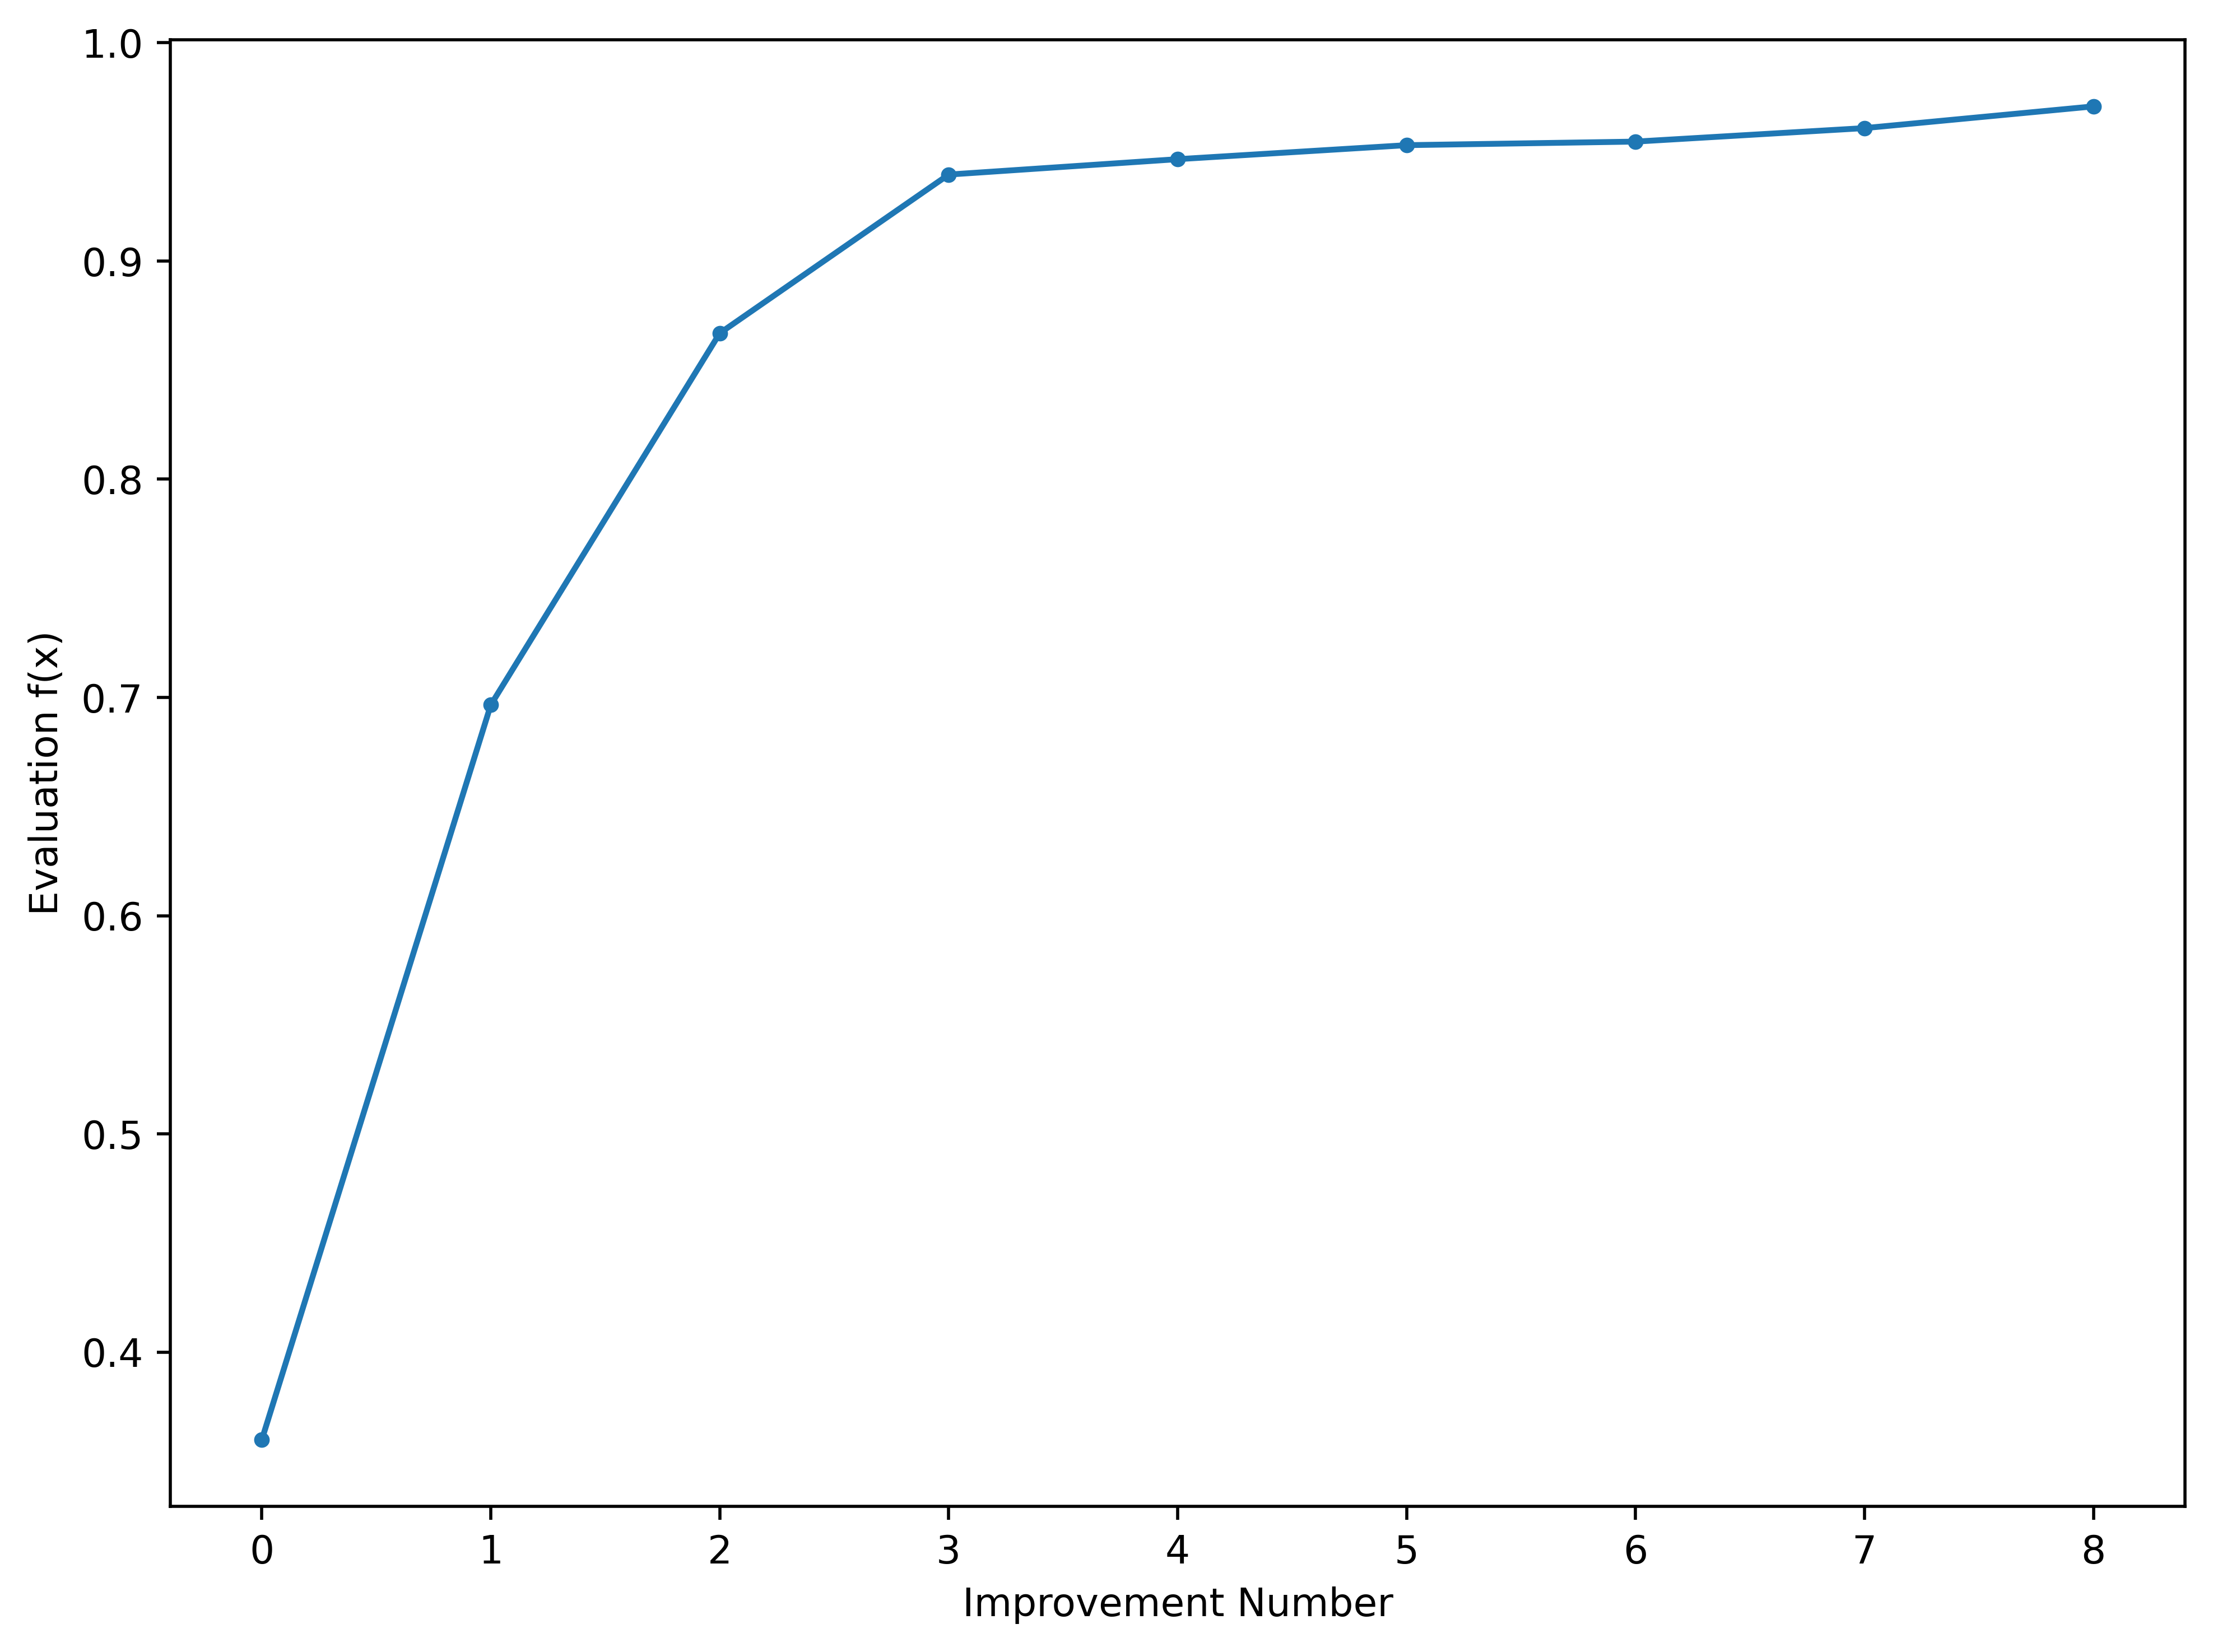

In [112]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=500, facecolor='w', edgecolor='k')
plt.plot(scores, '.-')
plt.xlabel('Improvement Number')
plt.ylabel('Evaluation f(x)')
plt.tight_layout()
#image_name = secret.replace('.','(dot)')
plt_dest = folder + "/Simulated_Annealing_Steps.pdf"
plt.savefig(plt_dest,
        bbox_inches="tight")
plt.show()

In [1]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=500, facecolor='w', edgecolor='k')
X = passwords
hv = np.vectorize(objective)
#plt.plot(X, hv(X))
plt.xlabel('Search Space')
plt.ylabel('Evaluation f(x)')
x_1 = []
y_1 = []
x_2 = []
y_2 = []
for password in passwords:
    if levenshtein_distance(secret, password) == 1:
        x_1.append(password)
        y_1.append(objective(password))
        
    elif levenshtein_distance(secret, password) == 2:
        x_2.append(password)
        y_2.append(objective(password))
        
plt.scatter(x_2, y_2, marker='v', color='orange', alpha=0.5, label='2-LevenshteinDistance')
plt.scatter(x_1, y_1, marker='o', color='black', alpha=0.5, label='1-LevenshteinDistance')
plt.scatter(best, best_eval, marker = 'X', color='green', label='Global Maxima')
plt.legend()
plt.plot(history, scores)
plt_dest = folder + "/Simulated_Annealing_Walkthrough.pdf"
#plt_dest = folder + "/Simulated_Annealing_Distance_Scores.pdf"
plt.savefig(plt_dest,
        bbox_inches="tight")
plt.show()

NameError: name 'plt' is not defined

In [2]:
def word_shape(text=None):
    if len(text) >= 100:
        return "LONG"
    shape = []
    last = ""
    shape_char = ""
    seq = 0
    for char in text:
        if char.isalpha():
            if char.isupper():
                shape_char = "X"
            else:
                shape_char = "x"
        elif char.isdigit():
            shape_char = "d"
        else:
            shape_char = char
        if shape_char == last:
            seq += 1
        else:
            seq = 0
            last = shape_char
        if seq < 4:
            shape.append(shape_char)
    return "".join(shape)

In [5]:
secrets   = ['abc123', 'aXY123', 'aRq123', 'a6a123', 'aKb123', 'agL123', 'aBv123', 'aYL123', 'aiu123', 'aln123', 'aSu123', 'aOR123', 'a1O123', 'ayN123', 'aDs123', 'axR123', 'a0x123', 'aJb123', 'aWi123', 'aX5123', 'a8X123', 'aoo123', 'aMK123', 'afN123', 'aVl123', 'adY123', 'aZl123', 'aPO123', 'a6f123', 'atB123', 'a0p123', 'aMv123', 'aiQ123', 'a0R123', 'a50123', 'aAV123', 'acK123', 'aNM123', 'a5I123', 'aOJ123', 'aBv123', 'aBC123', 'aLe123', 'am9123', 'a1Z123', 'aTq123', 'aCy123', 'aHi123', 'a9R123', 'a1N123']
extracted = ['abc123', 'aXY123', 'aRq123', 'a6a123', 'aKb123', 'ahP123', 'aBv123', 'aXX123', 'aiu123', 'awk123', 'aSu123', 'aOR123', 'a1O123', 'ayn123', 'aXx123', 'acJ123', 'a0x123', 'aJb123', 'aWi123', 'aX5123', 'a8X123', 'ank123', 'aMK123', 'avS123', 'aKv123', 'a0r123', 'aHm123', 'aPO123', 'aZX123', 'atB123', 'a0p123', 'aTx123', 'aaV123', 'a0R123', 'a50123', 'aaV123', 'ap5123', 'aNM123', 'a5I123', 'aDZ123', 'a0g123', 'aBC123', 'aFv123', 'aLT123', 'a5R123', 'aDi123', 'aJb123', 'aQa123', 'a9R123', 'a1N123']

In [6]:
from sklearn.metrics import accuracy_score

In [8]:
secrets_shape = [word_shape(secret) for secret in secrets]
extracted_shape = [word_shape(secret) for secret in extracted]

In [9]:
accuracy_score(secrets_shape, extracted_shape)

0.86

In [12]:
l1 = [1,2,3,4,5]
l2 = [2,3,4,5,7]
l3 = [4,5,6,7,8]

iterable = [l1,l2,l3]

l3 = list(zip(*iterable))

In [13]:
l3

[(1, 2, 4), (2, 3, 5), (3, 4, 6), (4, 5, 7), (5, 7, 8)]

In [21]:
avg_l = []
for l in l3:
    print(np.mean(np.array(l)))
    avg_l.append(np.mean(np.array(l)))

2.3333333333333335
3.3333333333333335
4.333333333333333
5.333333333333333
6.666666666666667


In [23]:
avg_l

[2.3333333333333335,
 3.3333333333333335,
 4.333333333333333,
 5.333333333333333,
 6.666666666666667]

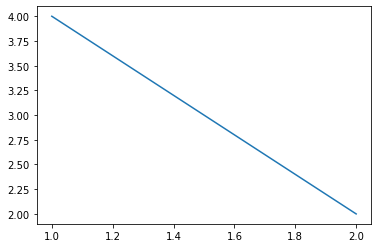

In [54]:
plt.figure()

l1 = [1,2]
l2 = [4,2]
l3 = [3,3]

iterable = [l1,l2,l3]
plt.plot(l1, l2)

In [55]:
zipped = list(zip(*iterable))

In [56]:
zipped

[(1, 4, 3), (2, 2, 3)]

In [61]:
res = sorted(zipped, key = lambda x: x[0])

In [62]:
res

[(1, 4, 3), (2, 2, 3)]

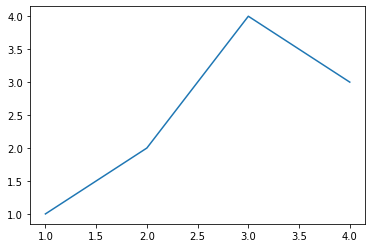

In [35]:
x = [i[0] for i in res]
y = [i[1] for i in res]
plt.plot(x, y)

In [2]:
insertions = 5
list(range(1,insertions+1))

[1, 2, 3, 4, 5]

In [36]:
epoch_rank_per_insertion = {insertion:{} for insertion in range(1,insertions+1)}

#epoch_rank_per_insertion = {insertion:{epoch:[] for epoch in range(1,50)} for insertion in range(1,insertions+1)}


In [37]:
epoch_rank_per_insertion

{1: {}, 2: {}, 3: {}, 4: {}, 5: {}}

In [27]:

for insertion in epoch_rank_per_insertion:
    epoch_rank_per_insertion[insertion] = {}

In [40]:
epoch = 1
for insertion in epoch_rank_per_insertion:
    if epoch in epoch_rank_per_insertion[insertion]:
        epoch_rank_per_insertion[insertion][epoch].append(123)
    else:
        epoch_rank_per_insertion[insertion][epoch] = []
        epoch_rank_per_insertion[insertion][epoch].append(123)

In [41]:
epoch_rank_per_insertion

{1: {2: [123], 1: [123]},
 2: {2: [123], 1: [123]},
 3: {2: [123], 1: [123]},
 4: {2: [123], 1: [123]},
 5: {2: [123], 1: [123]}}

In [82]:
for insertion in epoch_rank_per_insertion:
    epochs = []
    ranks = []
    for epoch in epoch_rank_per_insertion[insertion]:
        epochs.append(epoch)
        avg_rank = np.mean(np.array(epoch_rank_per_insertion[insertion][epoch]))
        epoch_rank_per_insertion[insertion][epoch] = avg_rank
        ranks.append(avg_rank)
    #epochs = list(epoch_rank_per_insertion[insertion].keys())
    #ranks = list(epoch_rank_per_insertion[insertion].values())
    print(epochs, ranks, insertion)

[1] [123.0] 1
[1] [123.0] 2
[1] [123.0] 3
[1] [123.0] 4
[1] [123.0] 5


In [77]:
epoch_rank_per_insertion

{1: {1: 123.0}, 2: {1: 123.0}, 3: {1: 123.0}, 4: {1: 123.0}, 5: {1: 123.0}}

In [1]:
import random

In [18]:
random.choices(list(range(2,6)), k=1)[0]

5

In [20]:
i = 100
list(range(i,10000,i*2))

[100,
 300,
 500,
 700,
 900,
 1100,
 1300,
 1500,
 1700,
 1900,
 2100,
 2300,
 2500,
 2700,
 2900,
 3100,
 3300,
 3500,
 3700,
 3900,
 4100,
 4300,
 4500,
 4700,
 4900,
 5100,
 5300,
 5500,
 5700,
 5900,
 6100,
 6300,
 6500,
 6700,
 6900,
 7100,
 7300,
 7500,
 7700,
 7900,
 8100,
 8300,
 8500,
 8700,
 8900,
 9100,
 9300,
 9500,
 9700,
 9900]

In [34]:
def word_shape(text=None):
    if len(text) >= 100:
        return "LONG"
    shape = []
    last = ""
    shape_char = ""
    seq = 0
    for char in text:
        if char.isalpha():
            if char.isupper():
                shape_char = "X"
            else:
                shape_char = "x"
        elif char.isdigit():
            shape_char = "d"
        else:
            shape_char = char
        if shape_char == last:
            seq += 1
        else:
            seq = 0
            last = shape_char
        if seq < 4:
            shape.append(shape_char)
    return "".join(shape)

In [93]:
import pickle
from sklearn.metrics import accuracy_score
path = "Results/Annealing Extraction/"

In [89]:
path = "Annealing Results/20210719_a_123_1_Missing_CHARS_100_iterations_Passwords_Simulated_Annealing_Extraction.pickle"

In [90]:
results = pickle.load(open(path, 'rb'))

In [91]:
results

[['ag123',
  'am123',
  'aW123',
  'ab123',
  'aS123',
  'a4123',
  'aT123',
  'aL123',
  'au123',
  'aj123',
  'a1123',
  'aA123',
  'a7123',
  'aj123',
  'aw123',
  'ap123',
  'aH123',
  'aB123',
  'aR123',
  'a2123',
  'an123',
  'aX123',
  'al123',
  'az123',
  'a0123',
  'ae123',
  'aa123',
  'ao123',
  'a2123',
  'ao123',
  'a5123',
  'a6123'],
 1,
 ['ag123',
  'am123',
  'aP123',
  'ab123',
  'aS123',
  'a4123',
  'aT123',
  'aL123',
  'au123',
  'aj123',
  'a1123',
  'aA123',
  'a7123',
  'aj123',
  'ap123',
  'ap123',
  'ap123',
  'aB123',
  'aR123',
  'a2123',
  'ap123',
  'aD123',
  'al123',
  'aP123',
  'a0123',
  'ae123',
  'aa123',
  'av123',
  'a2123',
  'ap123',
  'a5123',
  'a6123'],
 [0.938457177480144,
  0.9413925287145067,
  0.9877903464082252,
  0.96729332973992,
  0.9974023441579422,
  0.984515487951111,
  0.9886362166951271,
  0.9922334693658501,
  0.9554564255599598,
  0.984713656879805,
  0.9829120622417797,
  0.9953426083801958,
  0.9570882315870732,
  0.99101

In [66]:
selected_secrets = results[7]
selected_secrets_shape = [word_shape(secret) for secret in selected_secrets]
iteration_extracted = results[6]
selected_secret_num_missing = {2:[], 3:[], 4:[], 5:[]}
for secret in selected_secrets:
    num_missing = len(secret) - (len(secret[1]) + len(secret[-3:]))
    selected_secret_num_missing[num_missing].append(secret)
    
print([len(selected_secret_num_missing[num_missing]) for num_missing in selected_secret_num_missing])
    

accuracy_all = {100:{}, 200:{}, 400:{}, 800:{}, 1600:{}, 3200:{}, 6400:{}}
shape_accuracy_all = {100:{}, 200:{}, 400:{}, 800:{}, 1600:{}, 3200:{}, 6400:{}}

for iteration in iteration_extracted:
    extracted_secret = iteration_extracted[iteration]
    
    extracted_secret_num_missing = {2:[], 3:[], 4:[], 5:[]}
    
    for secret in extracted_secret:
        num_missing = len(secret) - (len(secret[1]) + len(secret[-3:]))
        extracted_secret_num_missing[num_missing].append(secret)
    
    for num_missing in extracted_secret_num_missing:
        extracted = extracted_secret_num_missing[num_missing]
        selected = selected_secret_num_missing[num_missing]
        extracted_shape = [word_shape(secret) for secret in extracted]
        selected_shape = [word_shape(secret) for secret in selected]
        print("iteration:{}, accuracy:{}, shape accuracy:{}".format(iteration, accuracy_score(extracted, selected), accuracy_score(extracted_shape, selected_shape)))
        
        accuracy_all[iteration][num_missing] = accuracy_score(extracted, selected)
        shape_accuracy_all[iteration][num_missing] = accuracy_score(extracted_shape, selected_shape)
    
#     print(len(extracted_secret))
#     extracted_secret_shape = [word_shape(secret) for secret in extracted_secret]
#     print(iteration, accuracy_score(extracted_secret, selected_secrets), accuracy_score(extracted_secret_shape, selected_secrets_shape))
    
    

[14, 10, 11, 15]
iteration:100, accuracy:0.0, shape accuracy:0.5714285714285714
iteration:100, accuracy:0.0, shape accuracy:0.1
iteration:100, accuracy:0.0, shape accuracy:0.09090909090909091
iteration:100, accuracy:0.0, shape accuracy:0.0
iteration:200, accuracy:0.14285714285714285, shape accuracy:0.42857142857142855
iteration:200, accuracy:0.0, shape accuracy:0.1
iteration:200, accuracy:0.0, shape accuracy:0.09090909090909091
iteration:200, accuracy:0.0, shape accuracy:0.0
iteration:400, accuracy:0.07142857142857142, shape accuracy:0.5714285714285714
iteration:400, accuracy:0.0, shape accuracy:0.1
iteration:400, accuracy:0.0, shape accuracy:0.18181818181818182
iteration:400, accuracy:0.0, shape accuracy:0.0
iteration:800, accuracy:0.21428571428571427, shape accuracy:0.5714285714285714
iteration:800, accuracy:0.0, shape accuracy:0.2
iteration:800, accuracy:0.0, shape accuracy:0.09090909090909091
iteration:800, accuracy:0.0, shape accuracy:0.0
iteration:1600, accuracy:0.214285714285714

In [67]:
print(" ", "2", "3", "4", "5")
for it in [100, 200, 400, 800, 1600, 3200, 6400]:
    print(it, accuracy_all[it][2], accuracy_all[it][3], accuracy_all[it][4], accuracy_all[it][5])

print(" ", "2", "3", "4", "5")
for it in [100, 200, 400, 800, 1600, 3200, 6400]:
    print(it, shape_accuracy_all[it][2], shape_accuracy_all[it][3], shape_accuracy_all[it][4], shape_accuracy_all[it][5])
  
    

  2 3 4 5
100 0.0 0.0 0.0 0.0
200 0.14285714285714285 0.0 0.0 0.0
400 0.07142857142857142 0.0 0.0 0.0
800 0.21428571428571427 0.0 0.0 0.0
1600 0.21428571428571427 0.1 0.0 0.0
3200 0.5 0.0 0.0 0.0
6400 0.42857142857142855 0.0 0.0 0.0
  2 3 4 5
100 0.5714285714285714 0.1 0.09090909090909091 0.0
200 0.42857142857142855 0.1 0.09090909090909091 0.0
400 0.5714285714285714 0.1 0.18181818181818182 0.0
800 0.5714285714285714 0.2 0.09090909090909091 0.0
1600 0.5714285714285714 0.2 0.09090909090909091 0.0
3200 0.7857142857142857 0.2 0.0 0.0
6400 0.7142857142857143 0.2 0.0 0.06666666666666667


In [39]:
list(range(2,6))

[2, 3, 4, 5]

In [10]:
iterations = 100
max_iterations = 10000
extracted_at_iteration={}
while iterations<=max_iterations:
    extracted_at_iteration[iterations] = []
    iterations = iterations*2
    
print(extracted_at_iteration)

{100: [], 200: [], 400: [], 800: [], 1600: [], 3200: [], 6400: []}


In [78]:
import multiprocessing as mp
mgr = mp.Manager()
    
secrets = ['abs123']
max_iterations = 400
extracted_at_iteration={secret:{} for secret in secrets}
for secret in secrets:
    iterations = 100
    while iterations<=max_iterations:
        extracted_at_iteration[secret][iterations] = 0
        iterations = iterations*2
extracted_at_iteration = mgr.dict(extracted_at_iteration)

In [85]:
def f(extracted_at_iteration, extracted):
    print(extracted_at_iteration['abs123'][100])
    extracted_at_iteration['abs123'][100] = 'abs123'
    print(extracted_at_iteration['abs123'][100])
    extracted.append('abs123')

In [87]:

extracted = mgr.list()
p1 = mp.Process(target=f, args=(extracted_at_iteration,extracted))
#p2 = mp.Process(target=f, args=(extracted_at_iteration,extracted))
p1.start()
#p2.start()
p1.join()
#p2.join()

0
0


In [88]:
dict(extracted_at_iteration), list(extracted)

({'abs123': {100: 0, 200: 0, 400: 0}}, ['abs123'])